In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

import asdf
from astropy.io import fits
from astropy.wcs import WCS
import ndcube

In [2]:
test = fits.open("test_data/ib6o23rsq_flt.fits")

In [3]:
test

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fadb8093310>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fadc91bb250>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fadc91bb670>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fadc91bb6d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fadc91bb910>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fadc91bbb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fadc91bbc70>]

In [4]:
test[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010'                                            
DATE    = '2016-09-14' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    6 / Number of standard extensions                  
FILENAME= 'ib6o23rsq_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

In [5]:
test[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1014                                                  
NAXIS2  =                 1014                                                  
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ORIGIN  = 'HSTIO/CFITSIO March 2010'                                            
DATE    = '2016-09-14' / date this file was written (yyyy-mm-dd)                
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib6o23rsq        

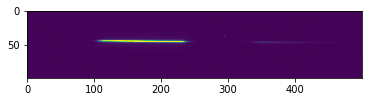

In [6]:
im = plt.imshow(test[1].data[250:350,100:600])
im.set_clim(0, 100)

In [7]:
w = WCS(test[1].header)

In [8]:
ndc = ndcube.NDCube(test[1].data, w)

In [9]:
ndc

NDCube
------
Dimensions: [1014. 1014.] pix
Physical Types of Axes: [('pos.eq.ra', 'pos.eq.dec'), ('pos.eq.ra', 'pos.eq.dec')]

In [10]:
reference_files = {}
specwcs_filename = "wfc3_ir_specwcs.asdf"
wavelengthrange_filename = "../WFC3_wavelengthrange.asdf"
dist_ref_path = "../WFC3IR_distortion.asdf"

reference_files['distortion'] = dist_ref_path
reference_files['wavelengthrange'] = wavelengthrange_filename
reference_files['specwcs'] = specwcs_filename

In [11]:
from dispersion_models import DISPXY_Model, DISPXY_Extension
asdf.get_config().add_extension(DISPXY_Extension())

specwcs = asdf.open(reference_files['specwcs']).tree
displ = specwcs['displ']
dispx = specwcs['dispx']
dispy = specwcs['dispy']
invdispl = specwcs['invdispl']
invdispx = specwcs['invdispx']
invdispy = specwcs['invdispy']
orders = specwcs['order']

In [12]:
invdispx

[<DISPXY_Model(name='DISPXY_Model')>,
 <DISPXY_Model(name='DISPXY_Model')>,
 <DISPXY_Model(name='DISPXY_Model')>,
 <DISPXY_Model(name='DISPXY_Model')>,
 <DISPXY_Model(name='DISPXY_Model')>,
 <DISPXY_Model(name='DISPXY_Model')>]

In [13]:
# Create grism pipeline

from gwcs import coordinate_frames as cf
from astropy import units as u
from transform_models import WFC3IRForwardGrismDispersion, WFC3IRBackwardGrismDispersion

gdetector = cf.Frame2D(name='grism_detector', 
                       axes_order=(0, 1),
                       unit=(u.pix, u.pix))
det2det = WFC3IRForwardGrismDispersion(orders,
                                        lmodels=displ,
                                        xmodels=invdispx,
                                        ymodels=dispy)
det2det.inverse = WFC3IRBackwardGrismDispersion(orders,
                                              lmodels=invdispl,
                                              xmodels=dispx,
                                              ymodels=dispy)

grism_pipeline = [(gdetector, det2det)]

In [14]:
from gwcs import WCS

wcsobj = WCS(grism_pipeline)

In [15]:
print(wcsobj)

     From      Transform
-------------- ---------
grism_detector      None


In [16]:
det2det.inverse.evaluate(100,100,2, 1)

(343.35376024540244, 104.13834046833674, 100, 100, 1)

In [63]:
from extraction import extract_2d_spectrum

sliced_data = extract_2d_spectrum(test[1].data, 160, 285, 165, 300)

(204.26972147408998, 286.8536012589572, 160, 285, 1) (339.55872878229144, 302.99753117068565, 165, 300, 1)


In [64]:
sliced_data.shape

(17, 136)

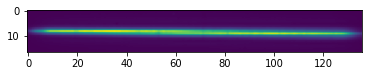

In [65]:
plt.imshow(sliced_data)